# Notebook 3: Model Setup and Evaluation

## Introduction

## Methodology

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
df = pd.read_csv('../data/restaurant_data_cleaned.csv')
df.head()

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,Cafes,Mexican,Bakeries,Japanese,Delis,Specialty Food,median_fans_per_user,checkins_per_week,reviews_per_week,tips_per_week
0,42.541155,-70.973438,4.0,39,1,1,1,1,1,2,...,0,0,0,0,0,0,0.0,0.076064,0.058773,0.041854
1,42.338544,-71.106842,2.5,24,1,1,0,1,1,1,...,0,0,0,0,0,0,9.0,0.473714,0.034599,0.036458
2,42.363442,-71.025781,3.5,856,1,0,1,1,1,2,...,0,0,0,0,0,0,3.0,5.808700,1.140674,0.366721
3,42.342673,-71.084239,4.5,7,0,1,0,1,1,1,...,0,0,0,0,0,0,0.0,0.428571,0.150769,0.125749
4,42.506935,-71.195854,3.0,16,0,1,1,1,1,1,...,0,0,0,0,0,0,0.0,0.071721,0.000000,0.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10481 entries, 0 to 10480
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    10481 non-null  float64
 1   longitude                   10481 non-null  float64
 2   stars                       10481 non-null  float64
 3   review_count                10481 non-null  int64  
 4   is_open                     10481 non-null  int64  
 5   RestaurantsGoodForGroups    10481 non-null  int64  
 6   HasTV                       10481 non-null  int64  
 7   GoodForKids                 10481 non-null  int64  
 8   RestaurantsTakeOut          10481 non-null  int64  
 9   RestaurantsPriceRange2      10481 non-null  int64  
 10  RestaurantsReservations     10481 non-null  int64  
 11  RestaurantsAttire           10481 non-null  object 
 12  RestaurantsDelivery         10481 non-null  int64  
 13  OutdoorSeating              104

### One Hot Encoding of Categorical Variables

In [4]:
# Get  columns whose data type is object
object_columns = df.dtypes[df.dtypes == 'object']

# Put the object column names into a list
object_columns = object_columns.index.tolist()
object_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi']

In [5]:
df[object_columns]

,RestaurantsAttire,NoiseLevel,Alcohol,WiFi
0,casual,average,none,free
1,casual,average,full_bar,free
2,casual,average,full_bar,free
3,casual,quiet,none,no
4,casual,average,none,no
...,...,...,...,...
10476,casual,quiet,none,no
10477,casual,average,full_bar,no
10478,dressy,average,beer_and_wine,no
10479,casual,average,beer_and_wine,no


In [6]:
pd.get_dummies(df[object_columns], drop_first=True)

,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,1,1,0
4,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
10476,0,0,0,1,0,0,1,1,0
10477,0,0,0,0,0,1,0,1,0
10478,1,0,0,0,0,0,0,1,0
10479,0,0,0,0,0,0,0,1,0


In [7]:
df = pd.concat([df, pd.get_dummies(df[object_columns], drop_first=True)], axis=1)
df.drop(object_columns, axis=1, inplace=True)

In [8]:
df.head()

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,tips_per_week,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,42.541155,-70.973438,4.0,39,1,1,1,1,1,2,...,0.041854,0,0,0,0,0,0,1,0,0
1,42.338544,-71.106842,2.5,24,1,1,0,1,1,1,...,0.036458,0,0,0,0,0,1,0,0,0
2,42.363442,-71.025781,3.5,856,1,0,1,1,1,2,...,0.366721,0,0,0,0,0,1,0,0,0
3,42.342673,-71.084239,4.5,7,0,1,0,1,1,1,...,0.125749,0,0,0,1,0,0,1,1,0
4,42.506935,-71.195854,3.0,16,0,1,1,1,1,1,...,0.000000,0,0,0,0,0,0,1,1,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10481 entries, 0 to 10480
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    10481 non-null  float64
 1   longitude                   10481 non-null  float64
 2   stars                       10481 non-null  float64
 3   review_count                10481 non-null  int64  
 4   is_open                     10481 non-null  int64  
 5   RestaurantsGoodForGroups    10481 non-null  int64  
 6   HasTV                       10481 non-null  int64  
 7   GoodForKids                 10481 non-null  int64  
 8   RestaurantsTakeOut          10481 non-null  int64  
 9   RestaurantsPriceRange2      10481 non-null  int64  
 10  RestaurantsReservations     10481 non-null  int64  
 11  RestaurantsDelivery         10481 non-null  int64  
 12  OutdoorSeating              10481 non-null  int64  
 13  BusinessAcceptsCreditCards  104

In [10]:
X = df.drop('stars', axis=1)
X.head()

,latitude,longitude,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,RestaurantsReservations,...,tips_per_week,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,42.541155,-70.973438,39,1,1,1,1,1,2,0,...,0.041854,0,0,0,0,0,0,1,0,0
1,42.338544,-71.106842,24,1,1,0,1,1,1,0,...,0.036458,0,0,0,0,0,1,0,0,0
2,42.363442,-71.025781,856,1,0,1,1,1,2,0,...,0.366721,0,0,0,0,0,1,0,0,0
3,42.342673,-71.084239,7,0,1,0,1,1,1,0,...,0.125749,0,0,0,1,0,0,1,1,0
4,42.506935,-71.195854,16,0,1,1,1,1,1,0,...,0.000000,0,0,0,0,0,0,1,1,0


In [11]:
y = df['stars']
y.head()

0    4.0
1    2.5
2    3.5
3    4.5
4    3.0
Name: stars, dtype: float64

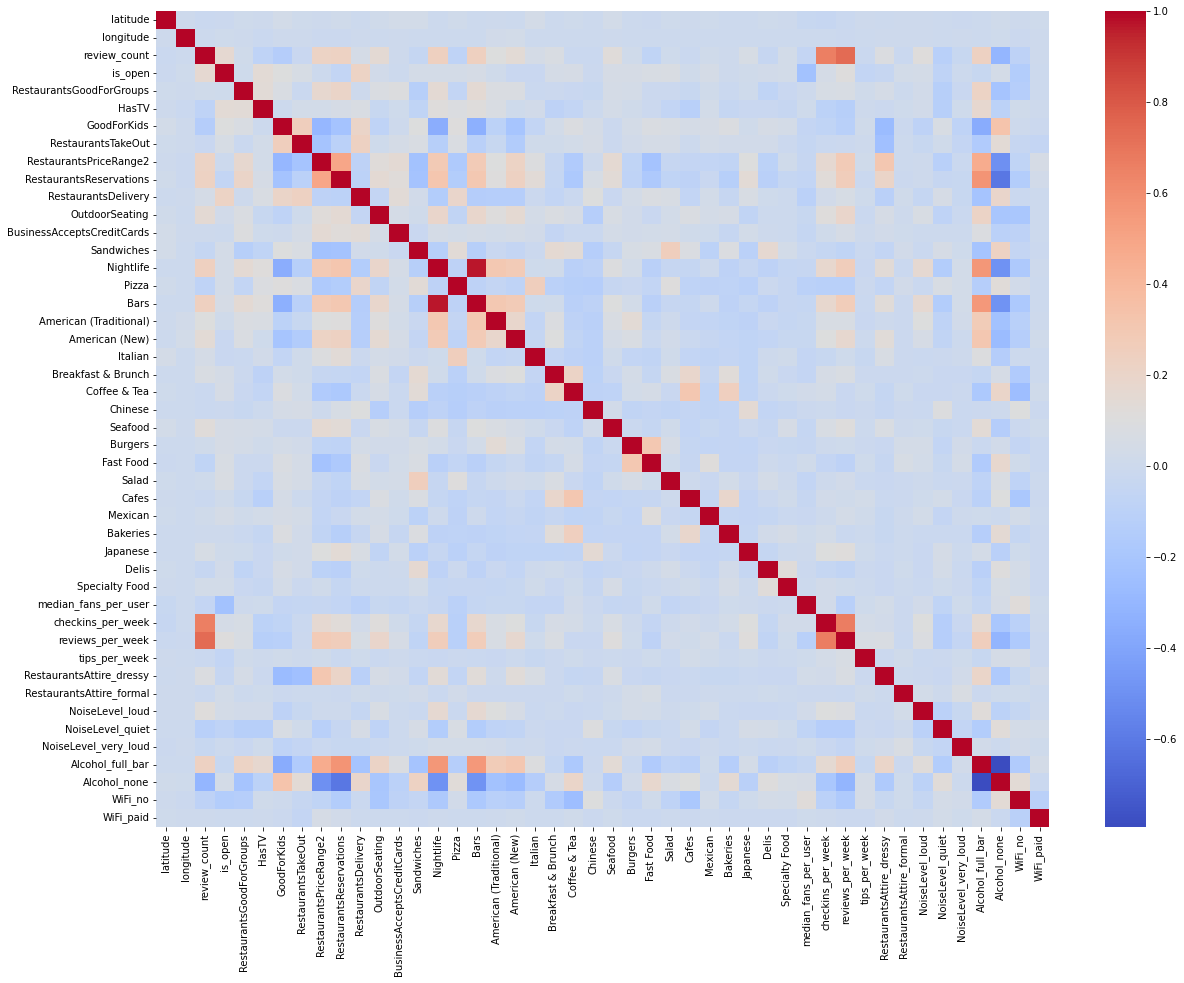

In [22]:
plt.figure(figsize=(20,15))
#mask = np.triu(np.ones_like(X.corr()))

sns.heatmap(X.corr(), cmap='coolwarm')
plt.show()

In [13]:
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
          index=X.columns).sort_values(ascending=False)

latitude                      2662.891382
longitude                     2579.878413
RestaurantsTakeOut              27.102772
BusinessAcceptsCreditCards      23.733612
Nightlife                       21.603272
Bars                            21.067431
RestaurantsPriceRange2          15.565550
GoodForKids                      8.488755
Alcohol_none                     8.487701
RestaurantsGoodForGroups         6.107453
HasTV                            5.302901
Alcohol_full_bar                 4.766348
reviews_per_week                 4.315075
RestaurantsDelivery              3.916329
review_count                     3.612782
WiFi_no                          3.498756
is_open                          3.168697
RestaurantsReservations          2.860221
checkins_per_week                2.791397
Pizza                            1.619444
OutdoorSeating                   1.559482
Coffee & Tea                     1.529836
Sandwiches                       1.526075
American (Traditional)           1

In [14]:
X_reduced = X.drop('latitude', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

longitude                     87.632854
RestaurantsTakeOut            26.872254
BusinessAcceptsCreditCards    23.581305
Nightlife                     21.601107
Bars                          21.066572
RestaurantsPriceRange2        15.507855
GoodForKids                    8.476441
Alcohol_none                   8.435914
RestaurantsGoodForGroups       6.099603
HasTV                          5.302743
Alcohol_full_bar               4.758693
reviews_per_week               4.314865
RestaurantsDelivery            3.916068
review_count                   3.612381
WiFi_no                        3.492765
is_open                        3.166267
RestaurantsReservations        2.860206
checkins_per_week              2.791394
Pizza                          1.619405
OutdoorSeating                 1.559482
Coffee & Tea                   1.529446
Sandwiches                     1.525798
American (Traditional)         1.426928
American (New)                 1.395654
median_fans_per_user           1.347486


In [15]:
X_reduced = X_reduced.drop('RestaurantsTakeOut', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

longitude                     66.091908
BusinessAcceptsCreditCards    23.519123
Nightlife                     21.567256
Bars                          21.033964
RestaurantsPriceRange2        15.338717
Alcohol_none                   8.435736
GoodForKids                    8.348093
RestaurantsGoodForGroups       6.098275
HasTV                          5.297015
Alcohol_full_bar               4.758064
reviews_per_week               4.311399
RestaurantsDelivery            3.822597
review_count                   3.612234
WiFi_no                        3.486505
is_open                        3.164909
RestaurantsReservations        2.858944
checkins_per_week              2.790201
Pizza                          1.619381
OutdoorSeating                 1.555676
Coffee & Tea                   1.529379
Sandwiches                     1.525356
American (Traditional)         1.425938
American (New)                 1.389178
median_fans_per_user           1.347359
Italian                        1.328861


In [16]:
X_reduced = X_reduced.drop('BusinessAcceptsCreditCards', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

longitude                   49.984421
Nightlife                   21.564686
Bars                        21.030688
RestaurantsPriceRange2      15.128955
Alcohol_none                 8.429579
GoodForKids                  8.344051
RestaurantsGoodForGroups     6.084164
HasTV                        5.296610
Alcohol_full_bar             4.758016
reviews_per_week             4.308863
RestaurantsDelivery          3.745445
review_count                 3.601201
WiFi_no                      3.479670
is_open                      3.159232
RestaurantsReservations      2.854638
checkins_per_week            2.790116
Pizza                        1.616858
OutdoorSeating               1.555477
Coffee & Tea                 1.528893
Sandwiches                   1.525165
American (Traditional)       1.424696
American (New)               1.388754
median_fans_per_user         1.347139
Italian                      1.328860
NoiseLevel_quiet             1.326531
Fast Food                    1.319889
Breakfast & 

In [17]:
X_reduced = X_reduced.drop('Nightlife', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

longitude                   49.871303
RestaurantsPriceRange2      15.128947
Alcohol_none                 8.421894
GoodForKids                  8.296250
RestaurantsGoodForGroups     6.079739
HasTV                        5.296307
Alcohol_full_bar             4.756079
reviews_per_week             4.308557
RestaurantsDelivery          3.744463
review_count                 3.601004
WiFi_no                      3.479610
is_open                      3.159167
RestaurantsReservations      2.853025
checkins_per_week            2.790088
Bars                         2.015294
Pizza                        1.616592
OutdoorSeating               1.554799
Coffee & Tea                 1.528790
Sandwiches                   1.524949
American (Traditional)       1.423762
American (New)               1.388747
median_fans_per_user         1.345113
Italian                      1.327584
NoiseLevel_quiet             1.326335
Fast Food                    1.319845
Breakfast & Brunch           1.303254
Chinese     

In [18]:
X_reduced = X_reduced.drop('longitude', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

RestaurantsPriceRange2      10.677136
GoodForKids                  7.267515
Alcohol_none                 6.389959
RestaurantsGoodForGroups     5.793809
HasTV                        5.063688
Alcohol_full_bar             4.389800
reviews_per_week             4.299328
RestaurantsDelivery          3.719788
review_count                 3.597517
is_open                      3.126213
WiFi_no                      3.114457
RestaurantsReservations      2.832572
checkins_per_week            2.789770
Bars                         1.989762
Pizza                        1.592712
OutdoorSeating               1.541791
Sandwiches                   1.500747
Coffee & Tea                 1.494663
American (Traditional)       1.415569
American (New)               1.384738
median_fans_per_user         1.319228
Italian                      1.313144
Fast Food                    1.306423
Breakfast & Brunch           1.296489
NoiseLevel_quiet             1.282353
Chinese                      1.264944
Cafes       

In [19]:
X_reduced = X_reduced.drop('RestaurantsPriceRange2', axis=1)
pd.Series([variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])],
          index=X_reduced.columns).sort_values(ascending=False)

GoodForKids                 7.191759
Alcohol_none                6.161252
RestaurantsGoodForGroups    5.523867
HasTV                       4.991663
reviews_per_week            4.219457
Alcohol_full_bar            4.131198
RestaurantsDelivery         3.671129
review_count                3.595677
is_open                     3.087105
WiFi_no                     2.921397
checkins_per_week           2.789645
RestaurantsReservations     2.624960
Bars                        1.985500
Pizza                       1.588285
OutdoorSeating              1.537789
Sandwiches                  1.499309
Coffee & Tea                1.494259
American (Traditional)      1.413089
American (New)              1.371240
median_fans_per_user        1.312940
Italian                     1.298206
Breakfast & Brunch          1.295679
Fast Food                   1.294396
NoiseLevel_quiet            1.280263
Chinese                     1.264871
Burgers                     1.257847
Cafes                       1.253418
B

In [20]:
#X = X.drop(['review_count', 'Nightlife', 'Alcohol_none'], axis=1)

#scaler=MinMaxScaler()
#X_reduced = scaler.fit_transform(X_reduced)

# Add our constant and inspect the df
X_with_constant = sm.add_constant(X_reduced)


# Create a model
linear_model = sm.OLS(y, X_with_constant)

# Fit the model
linear_model = linear_model.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  stars   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     73.46
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        23:45:51   Log-Likelihood:                -10150.
No. Observations:               10481   AIC:                         2.038e+04
Df Residuals:                   10440   BIC:                         2.068e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.5012      0.037     94.060      0.000       3.428       3.574
review_count                -0.0002   4.68e-05     -4.224      0.000      -0.000      -0.000
is_open                      0.2149      0.014     15.170      0.000       0.187       0.243
RestaurantsGoodForGroups    -0.0108      0.017     -0.630      0.529      -0.044       0.023
HasTV                       -0.1454      0.016     -8.944      0.000      -0.177      -0.114
GoodForKids                  0.1390      0.020      7.099      0.000       0.101       0.177
RestaurantsReservations     -0.0129      0.018     -0.704      0.481      -0.049       0.023
RestaurantsDelivery         -0.0709      0.015     -4.811      0.000      -0.100      -0.042
OutdoorSeating               0.0378      0.015      2.497      0.013       0.008       0.068
Sandwiches                   0.0183      0.018      1.012      0.312      -0.017       0.054
Pizza                       -0.1727      0.019     -9.057      0.000      -0.210      -0.135
Bars                         0.0748      0.022      3.439      0.001       0.032       0.117
American (Traditional)      -0.0885      0.020     -4.350      0.000      -0.128      -0.049
American (New)               0.0489      0.021      2.302      0.021       0.007       0.091
Italian                      0.1123      0.021      5.304      0.000       0.071       0.154
Breakfast & Brunch           0.0422      0.022      1.959      0.050   -2.14e-05       0.084
Coffee & Tea                -0.1197      0.024     -4.909      0.000      -0.168      -0.072
Chinese                     -0.2379      0.025     -9.599      0.000      -0.287      -0.189
Seafood                      0.0098      0.025      0.396      0.692      -0.039       0.058
Burgers                     -0.2504      0.027     -9.213      0.000      -0.304      -0.197
Fast Food                   -0.6528      0.028    -23.212      0.000      -0.708      -0.598
Salad                        0.0166      0.027      0.609      0.542      -0.037       0.070
Cafes                        0.2073      0.029      7.133      0.000       0.150       0.264
Mexican                     -0.0494      0.029     -1.680      0.093      -0.107       0.008
Bakeries                     0.1149      0.030      3.824      0.000       0.056       0.174
Japanese                     0.0279      0.031      0.911      0.362      -0.032       0.088
Delis                        0.1547      0.033      4.742      0.000       0.091       0.219
Specialty Food               0.2948      0.033      9.020      0.000       0.231       0.359
median_fans_per_user        -0.0012      0.002     -0.524      0.600      -0.006       0.003
checkins_per_week            0.0031      0.008      0.364      0.716      -0.013       0.020
reviews_per_we

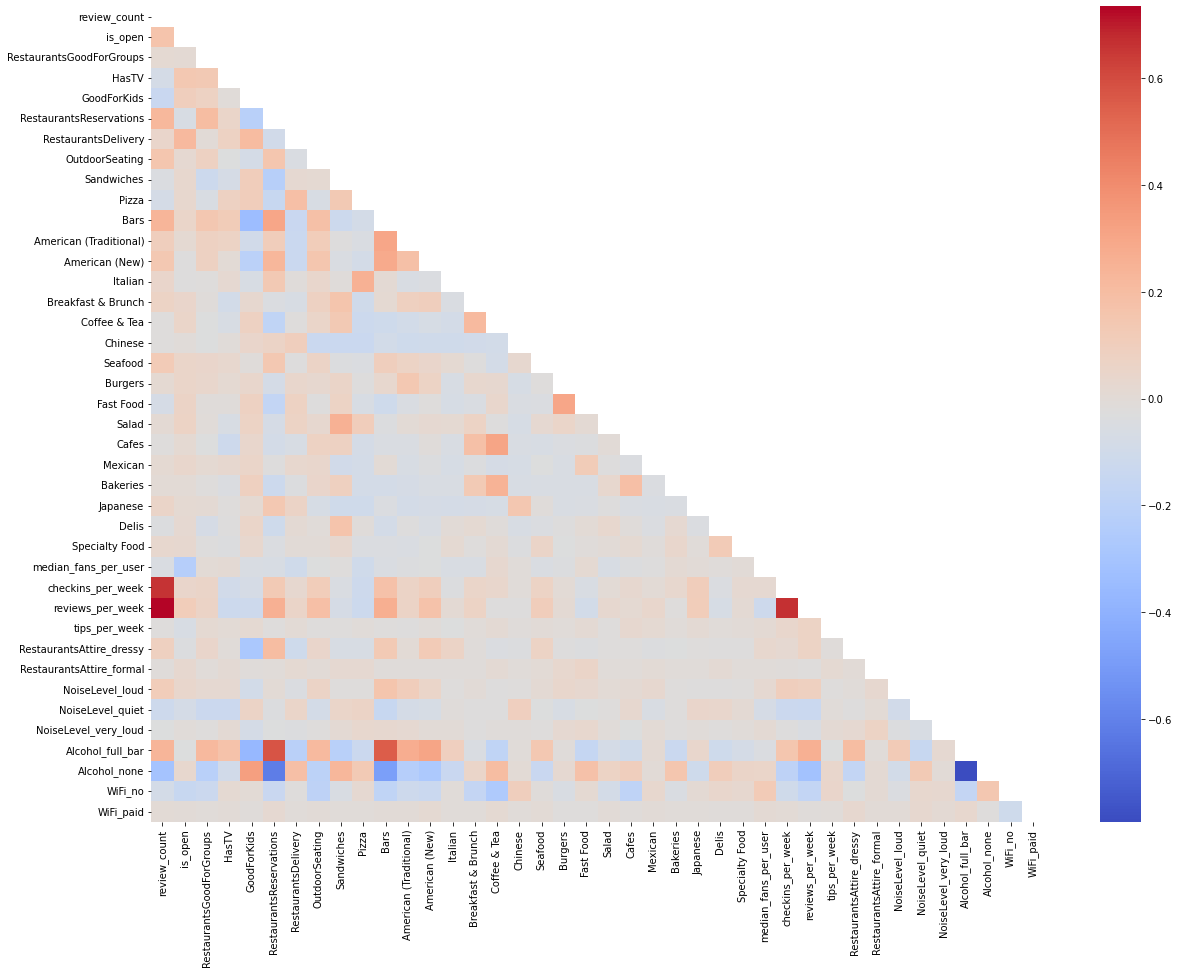

In [21]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(X_reduced.corr()))

sns.heatmap(X_reduced.corr(), cmap='coolwarm', mask=mask)
plt.show()

In [13]:
df.corr()['stars'].sort_values(ascending=False)

stars                         1.000000
reviews_per_week              0.229150
review_count                  0.146092
checkins_per_week             0.139551
is_open                       0.128617
Cafes                         0.122782
Specialty Food                0.120997
RestaurantsPriceRange2        0.103453
Bakeries                      0.090964
Breakfast & Brunch            0.088539
OutdoorSeating                0.073760
Delis                         0.067590
GoodForKids                   0.058860
Italian                       0.044045
RestaurantsReservations       0.040099
Japanese                      0.036442
Salad                         0.034052
Seafood                       0.032400
Bars                          0.030362
American (New)                0.026829
Nightlife                     0.024161
latitude                      0.023665
Sandwiches                    0.022748
Coffee & Tea                  0.021090
NoiseLevel_quiet              0.008212
longitude                

In [14]:
# Add our constant and inspect the df
X_with_constant = sm.add_constant(X)

X_with_constant.head()

,const,latitude,longitude,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,tips_per_week,RestaurantsAttire_dressy,RestaurantsAttire_formal,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Alcohol_full_bar,Alcohol_none,WiFi_no,WiFi_paid
0,1.0,42.541155,-70.973438,39,1,1,1,1,1,2,...,0.041854,0,0,0,0,0,0,1,0,0
1,1.0,42.338544,-71.106842,24,1,1,0,1,1,1,...,0.036458,0,0,0,0,0,1,0,0,0
2,1.0,42.363442,-71.025781,856,1,0,1,1,1,2,...,0.366721,0,0,0,0,0,1,0,0,0
3,1.0,42.342673,-71.084239,7,0,1,0,1,1,1,...,0.125749,0,0,0,1,0,0,1,1,0
4,1.0,42.506935,-71.195854,16,0,1,1,1,1,1,...,0.000000,0,0,0,0,0,0,1,1,0


In [15]:


# Create a model
linear_model = sm.OLS(y, X_with_constant)

# Fit the model
linear_model = linear_model.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  stars   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     67.60
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:15:37   Log-Likelihood:                -10083.
No. Observations:               10481   AIC:                         2.026e+04
Df Residuals:                   10434   BIC:                         2.060e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.6607      2.871     -1.624      0.105     -10.288       0.966
latitude                       0.2038      0.067      3.026      0.002       0.072       0.336
longitude                      0.0036      0.004      0.799      0.424      -0.005       0.012
review_count                  -0.0002   4.66e-05     -4.743      0.000      -0.000      -0.000
is_open                        0.2070      0.014     14.670      0.000       0.179       0.235
RestaurantsGoodForGroups      -0.0058      0.017     -0.343      0.732      -0.039       0.028
HasTV                         -0.1455      0.016     -8.997      0.000      -0.177      -0.114
GoodForKids                    0.1486      0.020      7.503      0.000       0.110       0.187
RestaurantsTakeOut            -0.0207      0.033     -0.628      0.530      -0.085       0.044
RestaurantsPriceRange2         0.0595      0.014      4.352      0.000       0.033       0.086
RestaurantsReservations       -0.0169      0.019     -0.907      0.365      -0.053       0.020
RestaurantsDelivery           -0.0493      0.015     -3.287      0.001      -0.079      -0.020
OutdoorSeating                 0.0401      0.015      2.658      0.008       0.011       0.070
BusinessAcceptsCreditCards    -0.3304      0.031    -10.686      0.000      -0.391      -0.270
Sandwiches                     0.0244      0.018      1.350      0.177      -0.011       0.060
Nightlife                     -0.0568      0.069     -0.822      0.411      -0.192       0.079
Pizza                         -0.1578      0.019     -8.269      0.000      -0.195      -0.120
Bars                           0.1290      0.070      1.845      0.065      -0.008       0.266
American (Traditional)        -0.0820      0.020     -4.050      0.000      -0.122      -0.042
American (New)                 0.0473      0.021      2.228      0.026       0.006       0.089
Italian                        0.1079      0.021      5.117      0.000       0.067       0.149
Breakfast & Brunch             0.0340      0.021      1.589      0.112      -0.008       0.076
Coffee & Tea                  -0.1116      0.024     -4.592      0.000      -0.159      -0.064
Chinese                       -0.2376      0.025     -9.625      0.000      -0.286      -0.189
Seafood                        0.0059      0.025      0.240      0.810      -0.042       0.054
Burgers                       -0.2468      0.027     -9.135      0.000      -0.300      -0.194
Fast Food                     -0.6208      0.028    -21.962      0.000      -0.676      -0.565
Salad                          0.0224      0.027      0.826      0.409      -0.031       0.075
Cafes                          0.2190      0.029      7.574      0.000       0.162       0.276
Mexican                       -0.0370      

In [16]:
X = X.drop(['review_count', 'Nightlife', 'Alcohol_none'], axis=1)

scaler=MinMaxScaler()
X = scaler.fit_transform(X)

# Add our constant and inspect the df
X_with_constant = sm.add_constant(X)


# Create a model
linear_model = sm.OLS(y, X_with_constant)

# Fit the model
linear_model = linear_model.fit()
linear_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  stars   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     71.33
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:15:37   Log-Likelihood:                -10100.
No. Observations:               10481   AIC:                         2.029e+04
Df Residuals:                   10437   BIC:                         2.061e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6456      0.053     68.401      0.000       3.541       3.750
x1             0.1037      0.036      2.875      0.004       0.033       0.174
x2             0.4957      0.636      0.779      0.436      -0.752       1.743
x3             0.1961      0.014     14.056      0.000       0.169       0.223
x4             0.0007      0.017      0.040      0.968      -0.033       0.034
x5            -0.1456      0.016     -8.996      0.000      -0.177      -0.114
x6             0.1524      0.020      7.725      0.000       0.114       0.191
x7            -0.0203      0.033     -0.614      0.539      -0.085       0.044
x8             0.2007      0.041      4.923      0.000       0.121       0.281
x9            -0.0072      0.018     -0.400      0.689      -0.043       0.028
x10           -0.0551      0.015     -3.681      0.000      -0.084      -0.026
x11            0.0409      0.015      2.710      0.007       0.011       0.070
x12           -0.3197      0.031    -10.345      0.000      -0.380      -0.259
x13            0.0208      0.018      1.148      0.251      -0.015       0.056
x14           -0.1608      0.019     -8.421      0.000      -0.198      -0.123
x15            0.0795      0.022      3.681      0.000       0.037       0.122
x16           -0.0864      0.020     -4.269      0.000      -0.126      -0.047
x17            0.0469      0.021      2.206      0.027       0.005       0.088
x18            0.1092      0.021      5.197      0.000       0.068       0.150
x19            0.0292      0.021      1.363      0.173      -0.013       0.071
x20           -0.1171      0.024     -4.816      0.000      -0.165      -0.069
x21           -0.2393      0.025     -9.685      0.000      -0.288      -0.191
x22            0.0005      0.025      0.020      0.984      -0.048       0.049
x23           -0.2471      0.027     -9.137      0.000      -0.300      -0.194
x24           -0.6242      0.028    -22.066      0.000      -0.680      -0.569
x25            0.0232      0.027      0.854      0.393      -0.030       0.076
x26            0.2225      0.029      7.687      0.000       0.166       0.279
x27           -0.0366      0.029     -1.248      0.212      -0.094       0.021
x28            0.0978      0.030      3.276      0.001       0.039       0.156
x29            0.0421      0.030      1.390      0.165      -0.017       0.102
x30            0.1665      0.032      5.125      0.000       0.103       0.230
x31            0.2834      0.033      8.702      0.000       0.220       0.347
x32           -0.0923      0.122     -0.760      0.447      -0.331       0.146
x33           -0.2686      0.232     -1.157      0.247      -0.723       0.186
x34            2.5647      0.170     15.096      0.000       2.232       2.898
x35            0.0018      0.284      0.006      0.995      -0.554       0.558
x3

In [17]:
X.corr().style.background_gradient(cmap='coolwarm')

AttributeError: 'numpy.ndarray' object has no attribute 'corr'